In [1]:
# Judul: Import Modules

import os
import zipfile
import shutil
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split


In [2]:
zip_path = '/content/dataset_padang.zip'
extract_path = '/content/padang_dataset'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Ekstrak file ZIP selesai.")


Ekstrak file ZIP selesai.


In [3]:
import os
import shutil
from sklearn.model_selection import train_test_split

extract_path = '/content/padang_dataset/dataset_padang_food'  # path folder utama kategori
train_dir = '/content/padang_split/train'
test_dir = '/content/padang_split/test'

os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

valid_exts = ('.jpg', '.jpeg', '.png')

categories = [d for d in os.listdir(extract_path) if os.path.isdir(os.path.join(extract_path, d))]
print("Kategori ditemukan:", categories)

for category in categories:
    print(f"Proses kategori: {category}")
    category_path = os.path.join(extract_path, category)

    # Cari semua gambar di subfolder kategori secara rekursif
    images = []
    for root, dirs, files in os.walk(category_path):
        for file in files:
            if file.lower().endswith(valid_exts):
                images.append(os.path.join(root, file))

    print(f"Jumlah gambar ditemukan: {len(images)}")

    # Pisah train/test
    train_imgs, test_imgs = train_test_split(images, test_size=0.2, random_state=42)

    # Buat folder train/test per kategori
    train_cat_dir = os.path.join(train_dir, category)
    test_cat_dir = os.path.join(test_dir, category)
    os.makedirs(train_cat_dir, exist_ok=True)
    os.makedirs(test_cat_dir, exist_ok=True)

    # Copy gambar ke folder train
    for img_path in train_imgs:
        shutil.copy(img_path, train_cat_dir)

    # Copy gambar ke folder test
    for img_path in test_imgs:
        shutil.copy(img_path, test_cat_dir)

print("Selesai pisah dataset train dan test dengan rekursif.")


Kategori ditemukan: ['telur_dadar', 'gulai_ikan', 'gulai_tunjang', 'ayam_goreng', 'gulai_tambusu', 'daging_rendang', 'dendeng_batokok', 'telur_balado', 'ayam_pop']
Proses kategori: telur_dadar
Jumlah gambar ditemukan: 116
Proses kategori: gulai_ikan
Jumlah gambar ditemukan: 111
Proses kategori: gulai_tunjang
Jumlah gambar ditemukan: 119
Proses kategori: ayam_goreng
Jumlah gambar ditemukan: 107
Proses kategori: gulai_tambusu
Jumlah gambar ditemukan: 103
Proses kategori: daging_rendang
Jumlah gambar ditemukan: 104
Proses kategori: dendeng_batokok
Jumlah gambar ditemukan: 109
Proses kategori: telur_balado
Jumlah gambar ditemukan: 111
Proses kategori: ayam_pop
Jumlah gambar ditemukan: 113
Selesai pisah dataset train dan test dengan rekursif.


In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

train_dir = '/content/padang_split/train'
categories = os.listdir(train_dir)
valid_exts = ('.jpg', '.jpeg', '.png')

sample_per_category = 3  # jumlah contoh gambar per kategori
plt.figure(figsize=(15, len(categories) * 3))

i = 1
for category in categories:
    category_path = os.path.join(train_dir, category)
    images = [f for f in os.listdir(category_path) if f.lower().endswith(valid_exts)]

    for img_name in images[:sample_per_category]:
        img_path = os.path.join(category_path, img_name)
        img = mpimg.imread(img_path)

        plt.subplot(len(categories), sample_per_category, i)
        plt.imshow(img)
        plt.axis('off')
        plt.title(category)
        i += 1

plt.tight_layout()
plt.show()


Output hidden; open in https://colab.research.google.com to view.

In [5]:
image_size = (150, 150)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

valid_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    '/content/padang_split/train',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

valid_generator = valid_datagen.flow_from_directory(
    '/content/padang_split/train',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

test_generator = valid_datagen.flow_from_directory(
    '/content/padang_split/test',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 635 images belonging to 9 classes.
Found 155 images belonging to 9 classes.
Found 203 images belonging to 9 classes.


In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

num_classes = len(train_generator.class_indices)

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(*image_size, 3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,829,513 (18.42 MB)

 Trainable params: 4,829,513 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define callbacks
early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=20,                # Wait 20 epochs for improvement before stopping
    restore_best_weights=True, # Restore model to best weights
    verbose=1
)

checkpoint = ModelCheckpoint(
    'best_model.h5',            # File to save the best model
    monitor='val_accuracy',
    save_best_only=True,        # Only save when val_accuracy improves
    verbose=1
)

# Train the model
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=50,
    callbacks=[early_stop, checkpoint]
)


Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - accuracy: 0.2194 - loss: 2.1278
Epoch 1: val_accuracy improved from -inf to 0.32903, saving model to best_model.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 473ms/step - accuracy: 0.2201 - loss: 2.1259 - val_accuracy: 0.3290 - val_loss: 1.8823
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - accuracy: 0.3530 - loss: 1.8567
Epoch 2: val_accuracy improved from 0.32903 to 0.45161, saving model to best_model.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 345ms/step - accuracy: 0.3520 - loss: 1.8551 - val_accuracy: 0.4516 - val_loss: 1.5769
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - accuracy: 0.3975 - loss: 1.6720
Epoch 3: val_accuracy improved from 0.45161 to 0.51613, saving model to best_model.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 312ms/step - accuracy: 0.3969 - loss: 1.6713 - val_accuracy: 0.5161 - val_loss: 1.4638
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step - accuracy: 0.3916 - loss: 1.5607
Epoch 4: val_accuracy did not improve from 0.51613
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 369ms/step - accuracy: 0.3923 - loss: 1.5614 - val_accuracy: 0.4774 - val_loss: 1.4122
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - accuracy: 0.4629 - loss: 1.4321
Epoch 5: val_accuracy improved from 0.51613 to 0.54839, saving model to best_model.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 355ms/step - accuracy: 0.4633 - loss: 1.4312 - val_accuracy: 0.5484 - val_loss: 1.1973
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.4975 - loss: 1.4113
Epoch 6: val_accuracy improved from 0.54839 to 0.58065, saving model to best_model.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 313ms/step - accuracy: 0.4978 - loss: 1.4091 - val_accuracy: 0.5806 - val_loss: 1.3232
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step - accuracy: 0.5058 - loss: 1.2651
Epoch 7: val_accuracy did not improve from 0.58065
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 353ms/step - accuracy: 0.5061 - loss: 1.2672 - val_accuracy: 0.5548 - val_loss: 1.2080
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - accuracy: 0.4927 - loss: 1.3519
Epoch 8: val_accuracy did not improve from 0.58065
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 304ms/step - accuracy: 0.4938 - loss: 1.3480 - val_accuracy: 0.5742 - val_loss: 1.2949
Epoch 9/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - accuracy: 0.5364 - loss: 1.2223
Epoch 9: val_accuracy improved from 0.58065 to 0.58710, saving model to best_model.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 371ms/step - accuracy: 0.5359 - loss: 1.2241 - val_accuracy: 0.5871 - val_loss: 1.2115
Epoch 10/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - accuracy: 0.5550 - loss: 1.2237
Epoch 10: val_accuracy improved from 0.58710 to 0.59355, saving model to best_model.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 339ms/step - accuracy: 0.5553 - loss: 1.2224 - val_accuracy: 0.5935 - val_loss: 1.1677
Epoch 11/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - accuracy: 0.5597 - loss: 1.1791
Epoch 11: val_accuracy improved from 0.59355 to 0.66452, saving model to best_model.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 321ms/step - accuracy: 0.5603 - loss: 1.1764 - val_accuracy: 0.6645 - val_loss: 1.0564
Epoch 12/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - accuracy: 0.6188 - loss: 1.0455
Epoch 12: val_accuracy did not improve from 0.66452
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 362ms/step - accuracy: 0.6183 - loss: 1.0466 - val_accuracy: 0.6194 - val_loss: 1.0412
Epoch 13/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - accuracy: 0.6166 - loss: 1.0564
Epoch 13: val_accuracy did not improve from 0.66452
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 335ms/step - accuracy: 0.6156 - loss: 1.0576 - val_accuracy: 0.6194 - val_loss: 1.1643
Epoch 14/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - accuracy: 0.6634 - loss: 0.9862
Epoch 14: val_accuracy improved from 0.66452 to 0.67097, saving model to best_model.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 339ms/step - accuracy: 0.6631 - loss: 0.9865 - val_accuracy: 0.6710 - val_loss: 1.0044
Epoch 15/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - accuracy: 0.6311 - loss: 1.0137
Epoch 15: val_accuracy improved from 0.67097 to 0.69677, saving model to best_model.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 365ms/step - accuracy: 0.6306 - loss: 1.0148 - val_accuracy: 0.6968 - val_loss: 1.0043
Epoch 16/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - accuracy: 0.6230 - loss: 1.0106
Epoch 16: val_accuracy did not improve from 0.69677
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 312ms/step - accuracy: 0.6232 - loss: 1.0110 - val_accuracy: 0.6581 - val_loss: 1.0260
Epoch 17/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step - accuracy: 0.6310 - loss: 0.9921
Epoch 17: val_accuracy did not improve from 0.69677
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 379ms/step - accuracy: 0.6311 - loss: 0.9922 - val_accuracy: 0.6774 - val_loss: 1.0321
Epoch 18/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - accuracy: 0.6243 - loss: 1.0294
Epoch 18: val_accuracy did not improve from 0.69677
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 319ms/step - accuracy: 0.6254 - loss: 1.0287 - val_accuracy: 0.6194 - val_loss: 1.0372
Epoch 19/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - accuracy: 0.6696 - loss: 0.9353
Epoch 19: val_accuracy did n

20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 359ms/step - accuracy: 0.6952 - loss: 0.8751 - val_accuracy: 0.7161 - val_loss: 0.9151
Epoch 28/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - accuracy: 0.7105 - loss: 0.8339
Epoch 28: val_accuracy did not improve from 0.71613
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 304ms/step - accuracy: 0.7107 - loss: 0.8313 - val_accuracy: 0.6968 - val_loss: 1.0128
Epoch 29/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - accuracy: 0.7432 - loss: 0.7284
Epoch 29: val_accuracy did not improve from 0.71613
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 355ms/step - accuracy: 0.7425 - loss: 0.7289 - val_accuracy: 0.6452 - val_loss: 1.2086
Epoch 30/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - accuracy: 0.7449 - loss: 0.7259
Epoch 30: val_accuracy did not improve from 0.71613
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 358ms/step - accuracy: 0.7435 - loss: 0.7277 - val_accuracy: 0.5935 - val_loss: 1.3040
Epoch 31/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - accuracy: 0.7237 - loss: 0.7155
Epoch 31: val_accuracy impr

20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 315ms/step - accuracy: 0.7247 - loss: 0.7149 - val_accuracy: 0.7355 - val_loss: 0.9093
Epoch 32/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - accuracy: 0.7745 - loss: 0.6564
Epoch 32: val_accuracy did not improve from 0.73548
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 355ms/step - accuracy: 0.7735 - loss: 0.6587 - val_accuracy: 0.6581 - val_loss: 1.0591
Epoch 33/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - accuracy: 0.7563 - loss: 0.6363
Epoch 33: val_accuracy did not improve from 0.73548
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 309ms/step - accuracy: 0.7567 - loss: 0.6360 - val_accuracy: 0.6516 - val_loss: 1.2866
Epoch 34/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - accuracy: 0.7756 - loss: 0.6213
Epoch 34: val_accuracy did not improve from 0.73548
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 356ms/step - accuracy: 0.7749 - loss: 0.6226 - val_accuracy: 0.6516 - val_loss: 1.3681
Epoch 35/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - accuracy: 0.7520 - loss: 0.6701
Epoch 35: val_accuracy did n

In [9]:
# Simpan model ke file
model.save('/content/model_padang_food.h5')
print("Model disimpan sebagai model_padang_food.h5")

# Load kembali model jika diperlukan
loaded_model = load_model('/content/model_padang_food.h5')
print("Model berhasil dimuat ulang.")


Model disimpan sebagai model_padang_food.h5
Model berhasil dimuat ulang.


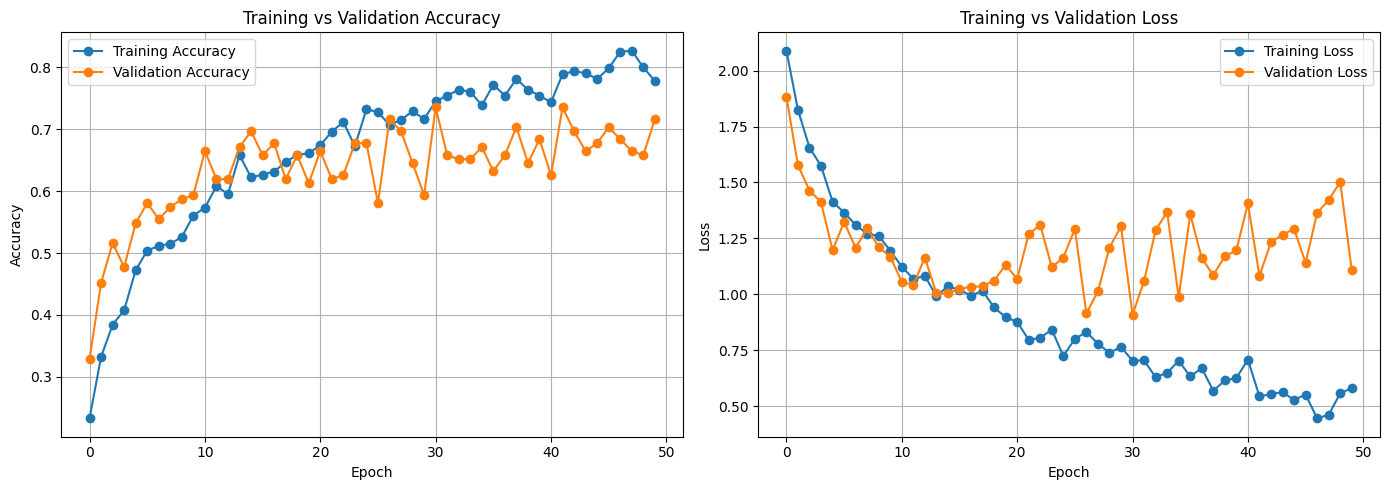

In [10]:
import matplotlib.pyplot as plt

# Ambil metrik dari history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Jumlah epoch aktual (misalnya jika early stopping menghentikan sebelum 500)
epochs_range = range(len(acc))

# Buat grafik
plt.figure(figsize=(14, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy', marker='o')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', marker='o')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss', marker='o')
plt.plot(epochs_range, val_loss, label='Validation Loss', marker='o')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


Saving ayam_goreng.jpg to ayam_goreng.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 651ms/step


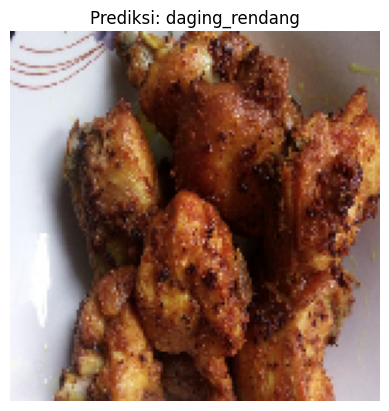

In [11]:
from tensorflow.keras.preprocessing import image
from google.colab import files
import numpy as np
import matplotlib.pyplot as plt
import PIL

# Upload gambar
uploaded = files.upload()

for img_name in uploaded.keys():
    img_path = img_name

    # Load dan preprocess gambar
    img = image.load_img(img_path, target_size=image_size)
    img_array = image.img_to_array(img) / 255.0  # Normalisasi
    img_array = np.expand_dims(img_array, axis=0)  # Ubah shape jadi (1, height, width, 3)

    # Prediksi
    prediction = loaded_model.predict(img_array)
    predicted_class = np.argmax(prediction, axis=1)[0]

    # Mapping indeks ke label
    class_indices = train_generator.class_indices
    label_map = dict((v,k) for k,v in class_indices.items())
    predicted_label = label_map[predicted_class]

    # Tampilkan gambar dan hasil prediksi
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Prediksi: {predicted_label}")
    plt.show()



In [12]:
!pip install anvil-uplink

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.9/97.9 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 4.2 MB/s eta 0:00:00


In [13]:
import anvil.server

In [14]:
anvil.server.connect("server_2MRPKLA6VDMVKUIRPMAFQRCP-LC4DX73CS6IOAZBK")

Connecting to wss://anvil.works/uplink
Anvil websocket open
Connected to "Debug for naufalhannan909@gmail.com" as SERVER


In [15]:
import anvil.server
import anvil.media
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import numpy as np

# Load model yang sudah dilatih
model = load_model('/content/model_padang_food.h5')

# Dapatkan label kelas dari train_generator
class_labels = list(train_generator.class_indices.keys())

@anvil.server.callable
def classify_food_image(file):
    """Fungsi untuk mengklasifikasikan gambar makanan Padang"""
    try:
        # Simpan file sementara dan proses
        with anvil.media.TempFile(file) as f:
            img = load_img(f, target_size=image_size)  # Gunakan image_size yang sama (150,150)
            img_array = img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0) / 255.0  # Normalisasi

            # Prediksi
            prediction = model.predict(img_array)
            pred_index = np.argmax(prediction[0])
            pred_label = class_labels[pred_index]
            confidence = float(np.max(prediction[0]))

            return {
                'status': 'success',
                'prediction': pred_label,
                'confidence': confidence,
                'all_predictions': {label: float(prob) for label, prob in zip(class_labels, prediction[0])}
            }

    except Exception as e:
        return {
            'status': 'error',
            'message': str(e)
        }

# Hubungkan ke Anvil
anvil.server.connect("server_2MRPKLA6VDMVKUIRPMAFQRCP-LC4DX73CS6IOAZBK")
print("Server connected and ready to receive calls from Anvil")

Server connected and ready to receive calls from Anvil
